# I - Importing Modules

We will import the basics (matplotlib and pandas) and a few specialty modules (vincenty, geocoder and time) to be used within the analysis.  We also created our own custom module (cleandata) to be used for loading and cleaning the raw data.  We wanted to separate the loading and cleaning of the data in order to focus this notebook on the analysis portion.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
% matplotlib inline
%load_ext autoreload
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.ticker as tkr
from vincenty import vincenty
import geocoder as geo
import datetime as dt
import cleandata as cd
import time

----

# II - Getting Started - Quick look at the raw data

To get started, we will first describe the data. The majority of the analysis will be centered around felony incidents in <a href='https://catalog.data.gov/dataset/nypd-7-major-felony-incidents'>New York City</a> and the school violence incidents within <a href='http://www.p12.nysed.gov/irs/school_safety/school_safety_data_reporting.html'>NYC Schools</a>. For our analysis, we will also need NYC population data as well as <a href='https://data.dcpcsb.org/Schools-/2015-16-School-Directory/3d2c-rrhw'>school location data</a>.

__NYC Felony Data__ "Quarterly update of Seven Major Felonies at the incident level. For privacy reasons, incidents have been moved to the midpoint of the street segment on which they occur."

For our purposes, we will be using the general wikipedia definitions of the 7 types of felonies. Note that these definitions can sometimes change from state to state:
- Grand larceny: theft of personal property having a value above a legally specified amount.
- Robbery: the taking of another person's property by force, fear, or intimidation, with the intent to permanently deprive that person of the property.
- Burglary: typically defined as the unlawful entry into almost any structure (not just a home or business) with the intent to commit any crime inside (not just theft/larceny). No physical breaking and entering is required; the offender may simply trespass through an open door. Unlike robbery, which involves use of force or fear to obtain another person's property, there is usually no victim present during a burglary.
- Assault: carried out by a threat of bodily harm coupled with an apparent, present ability to cause the harm.
- Grand Larceny of Motor Vehicle: the unlawful taking of property — in this case, a vehicle — that belongs to someone else, done with the intent to permanently deprive the owner of the property.
- Rape: non-consensual sexual intercourse that is committed by physical force, threat of injury, or other duress
- Murder & Non-negligent Manslaughter: The unjustifiable, inexcusable, and intentional killing of a human being with (murder) or without (non-negligent) deliberation, premeditation, and malice.

__NYC School Violence Data__ "...reports detailing the number of incidents relating to School Safety and the Educational Climate (SSEC) reported to SED for the specified school years."

__NYC Population Data__ NYC Population by borough

__NYC School Location Data__ 2015 - 2016 NYC School directory of all NYC schools and their addresses. 

----

# III - Importing and Cleaning Data

Import and clean the felony data and school violence data.  NYC School Location data doesn't need cleaning.  NOTE: this uses our custom cleandata module provide as part of the submitted zip file.

__NYC Felony Data Cleanup__
* Resetting index
* Removing data prior to 2006 because this data has year and date issues
* Ensuring that Occurrence Year data is correct
* Creating columns for month ordering, day of week ordering and school year (in order to join correctly to the School Violence data.

__NYC School Violence Cleanup__ 
* The 2010 - 2014 files have the same column names, so they're easy to import and concatenate. However, 2006 - 2009 years each have a few unique column names, so they must be concatenated independently to the main dataframe. 
* Moreover, some columns have "w/ weapon" and others have "w/out weapon" in the column names. These were suffixed with "_ww" and "_nw" for 'with weapon' and 'no weapon', respectively. 
* Also re-ordered columns, merged duplicate columns, removed problematic (non data) rows from the csv, and fixed inconsistencies. 
* Tallied number of incidents in total, with weapons, without weapons.
* Ensured that all records have valid County data.

__NYC Population Data Cleanup__
* Capitalize Boroughs and set them as indexes.  This is done to match NYC Felony Data.
* Add areas (measured in sq miles, source: wikipedia)

In [2]:
#takes about 5 minutes to load and clean
school_df = cd.load_and_clean_VADIR()
felony_df = cd.load_and_clean_NYPD()
borough_df = cd.load_and_clean_BORPOP()
location_df = pd.read_excel("15-16SchoolDirectory.xlsx")

... data from VADIR_2006.xls appended. Added 1455 rows for a total of 1455.
... data from VADIR_2007.xls appended. Added 1500 rows for a total of 2955.
... data from VADIR_2008.xls appended. Added 1545 rows for a total of 4500.
... data from VADIR_2009.xls appended. Added 1531 rows for a total of 6031.
... data from VADIR_2010.xls appended. Added 1678 rows for a total of 7709.
... data from VADIR_2011.xls appended. Added 1693 rows for a total of 9402.
... data from VADIR_2012.xls appended. Added 1735 rows for a total of 11137.
... data from VADIR_2013.xls appended. Added 1792 rows for a total of 12929.
... data from VADIR_2014.xls appended. Added 1805 rows for a total of 14734.
... loaded NYPD felony data: 1116904 observations


----

# IV - Analysis of NYPD 7 Major Felony Incidents


In [3]:
print("Number of observations:", len(felony_df), "\nNumber of Variables:", len(felony_df.columns),\
     "\nDate Range:", int(felony_df["Occurrence Year"].min()), "-", int(felony_df["Occurrence Year"].max()))

Number of observations: 1116904 
Number of Variables: 23 
Date Range: 2006 - 2015


Percent of data dated 2000 or after: 99.42%


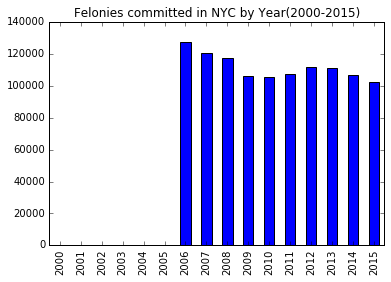

In [4]:
# what percent of the data is from 2006 and after?
year_counts = felony_df['Occurrence Year'].value_counts()
recent = year_counts[list(range(2006,2016))].sum()
print("Percent of data dated 2000 or after: {:.2f}%".format(recent/1123465 * 100))

# plot crime incidence by year (2000- 2015)
year_counts[list(range(2000,2016))].plot(kind = 'bar')
plt.title("Felonies committed in NYC by Year(2000-2015)")

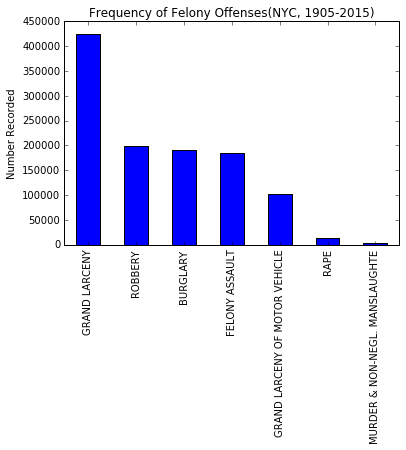

In [5]:
# plot crime incidence by felony type (whole data set)
felony_counts = felony_df.Offense.value_counts()
#counts.sort_values(inplace=True)
felony_counts.plot(kind = 'bar')
plt.title("Frequency of Felony Offenses(NYC, 1905-2015)")
plt.ylabel("Number Recorded")

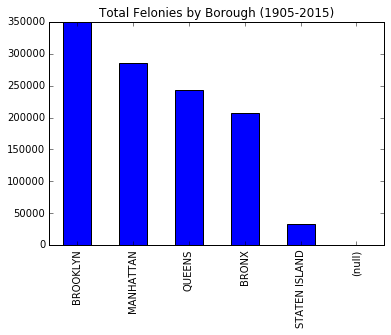

In [6]:
# plot crime incidence by borough (whole data set)
felony_df.Borough.value_counts().plot(kind = 'bar')
plt.title("Total Felonies by Borough (1905-2015)")

In [7]:
datecount = felony_df.groupby('Short Occurrence Date', as_index=False).Identifier.count()
yearcount = felony_df.groupby('Occurrence Year', as_index=False).Identifier.count()
monthcount = felony_df.groupby('Occurrence Month Ordered', as_index=False).Identifier.count()
daycount = felony_df.groupby('Occurrence Day', as_index=False).Identifier.count()
weekdaycount = felony_df.groupby('Day of Week Ordered', as_index=False).Identifier.count()
offensecount = felony_df.groupby('Offense', as_index=False).Identifier.count()
yearoffensecount = felony_df.groupby(['Occurrence Year', 'Offense'], as_index=False).Identifier.count()
yearoffensecountp = yearoffensecount.pivot('Occurrence Year', 'Offense', 'Identifier')

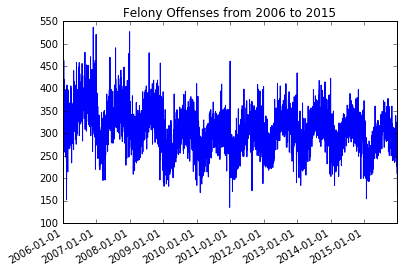

In [8]:
# get a time series view of the number of offenses per day
dates = datecount["Short Occurrence Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = datecount["Identifier"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2006 to 2015')

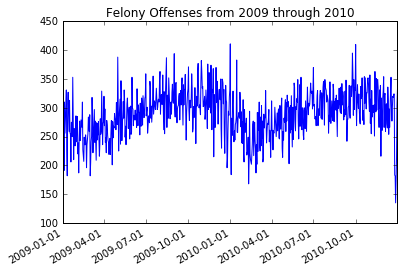

In [9]:
# there is an evident seasonal spike and valley in felonies each year
# the below shows a view for 2009 through 2010
datecount_2010 = datecount[datecount['Short Occurrence Date'] > '2008-12-31']
datecount_2010 = datecount_2010[datecount_2010['Short Occurrence Date'] < '2011-01-01']

dates = datecount_2010["Short Occurrence Date"]
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = datecount_2010["Identifier"]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('Felony Offenses from 2009 through 2010')

#looks like the number of felonies spike in September/October and 
# then fall back down at the end of each calendar year

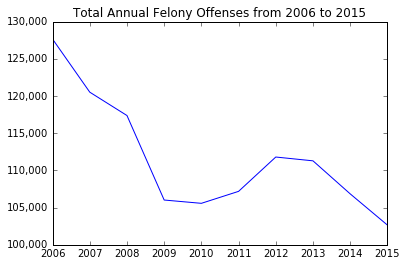

In [10]:
# this shows a decline in the number of felonies recorded from 2006 to 2015
# same graph as aaron had with the x axis labels as the years and y ticks labaels formatted
x = yearcount['Occurrence Year']
xlabels = [int(xl) for xl in x]
y = yearcount["Identifier"]

def func(x, pos):  
   s = '{:0,d}'.format(int(x))
   return s

y_format = tkr.FuncFormatter(func) 
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.plot(x,y)
plt.title('Total Annual Felony Offenses from 2006 to 2015')

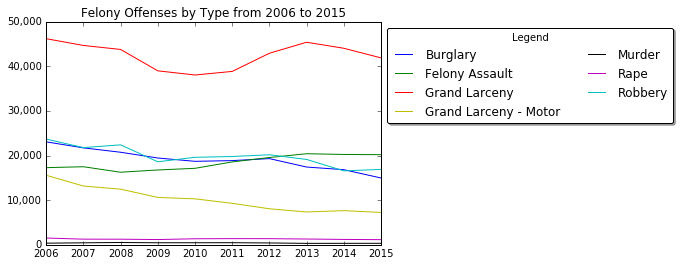

In [11]:
# wanted to see a breakout of the type of offenses across years

x = yearoffensecountp.index
xlabels = [int(xl) for xl in x]
yb = yearoffensecountp["BURGLARY"]
yfa = yearoffensecountp["FELONY ASSAULT"]
ygl = yearoffensecountp["GRAND LARCENY"]
yglmv = yearoffensecountp["GRAND LARCENY OF MOTOR VEHICLE"]
ymm = yearoffensecountp["MURDER & NON-NEGL. MANSLAUGHTE"]
yr = yearoffensecountp["RAPE"]
yrb = yearoffensecountp["ROBBERY"]

def func(x, pos):  
    s = '{:0,d}'.format(int(x))
    return s

y_format = tkr.FuncFormatter(func) 
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)

plt.plot(x, yb, 'b-', label='Burglary')
plt.plot(x, yfa, 'g-', label='Felony Assault')
plt.plot(x, ygl, 'r-', label='Grand Larceny')
plt.plot(x, yglmv, 'y-', label='Grand Larceny - Motor')
plt.plot(x, ymm, 'k-', label='Murder')
plt.plot(x, yr, 'm-', label='Rape')
plt.plot(x, yrb, 'c-', label='Robbery')

plt.legend(loc="best", bbox_to_anchor=[1, 1],
           ncol=2, shadow=True, title="Legend", fancybox=True)
plt.title('Felony Offenses by Type from 2006 to 2015')
plt.show()

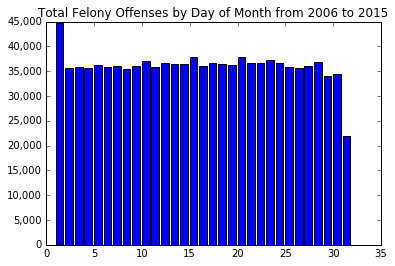

In [12]:
# there is a look of total felony offenses by day of week
# looks like the first of the month has the highest offenses - about 10,000 more than any other day
# perhaps this is just the busiest day to record offenses?
# 31 doesn't have as many offenses since not all months have 31 days - most likely
x = daycount['Occurrence Day']
y = daycount['Identifier']
plt.gca().yaxis.set_major_formatter(y_format)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Month from 2006 to 2015')

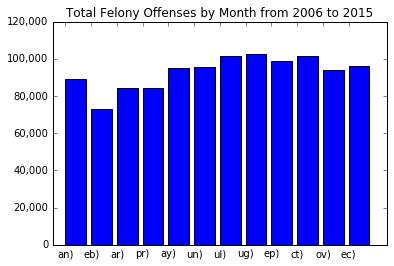

In [13]:
# breaking out the offenses by month total, it does look a bit seasonal and similar to the time series chart above
# February has the least number of offenses - potentially due to the cold weather in nyc
# need to determine how to center the month x axis tick labels
x = range(len(monthcount['Occurrence Month Ordered']))
xlabels = [x[-3:] for x in monthcount['Occurrence Month Ordered']]
y = monthcount['Identifier']
plt.xticks(x, xlabels)
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-0.5,len(xlabels)+0.5)
locs = np.arange(len(xlabels))
plt.bar(x,y)
plt.title('Total Felony Offenses by Month from 2006 to 2015')
plt.show()

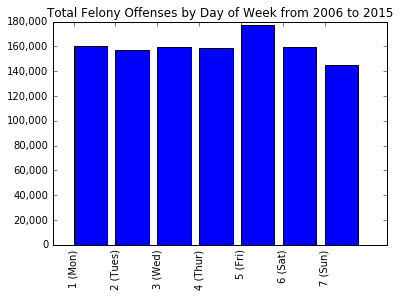

In [14]:
# breaking out offenses by day of week, Friday spikes with almost 20,000 more offenses than any other day
x = range(len(weekdaycount['Day of Week Ordered']))
xlabels = [x for x in weekdaycount['Day of Week Ordered']]
y = weekdaycount['Identifier']
plt.xticks(x, xlabels, rotation='vertical')
plt.gca().yaxis.set_major_formatter(y_format)
plt.gca().set_xlim(-0.5,len(xlabels)+0.5)
plt.bar(x,y)
plt.title('Total Felony Offenses by Day of Week from 2006 to 2015')
plt.show()

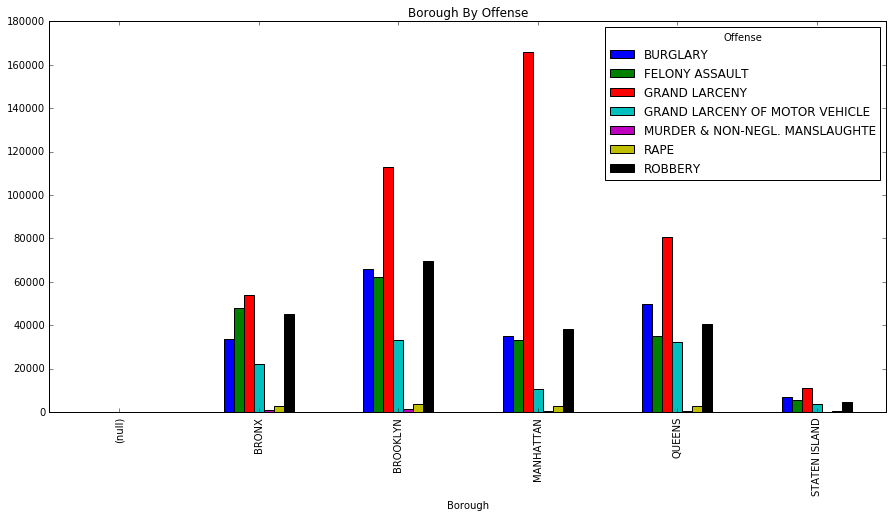

In [15]:
# create plot comparing types of Felonies by Borough
fel_by_bor = felony_df.groupby('Borough')['Offense'].value_counts().sort_values(ascending=False)
fel_by_bor_un = fel_by_bor.unstack("Offense")
fel_by_bor_un.sort_index(ascending=False, level = 'GRAND LARCENY')
fel_by_bor_un.plot(kind="bar", figsize= (15,7), title = "Borough By Offense")

-----

# V - NYC School Violence Data Analysis

In [16]:
school_df[school_df["School Year"].astype(int) > 2010]

,School Name,School Type,School Year,BEDS Code,County,District,Enrollment,Grade Organization,Need/Resource Category,Alcohol Possession,...,Reckless Endangerment_ww,Riot_nw,Riot_ww,Robbery_nw,Robbery_ww,Weapon Possession_oc,Weapon Possession_ts,Total Incidents,Incidents w/ Weapons,Incidents w/o Weapons
7709,Academic Leadership Charter School,Charter,2011,320700860957,Bronx,NaN,269,Elementary,Charter School,0,...,0,0,0,0,0,0,0,2,0,0
7710,Bronx Academy Of Promise Charter School,Charter,2011,320900860913,Bronx,NaN,342,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
7711,Bronx Charter School For Better Learning,Charter,2011,321100860855,Bronx,NaN,386,Elementary,Charter School,0,...,0,0,0,0,0,0,0,62,0,39
7712,Bronx Charter School For Children,Charter,2011,320700860852,Bronx,NaN,426,Elementary,Charter School,0,...,0,0,0,0,0,0,0,95,0,53
7713,Bronx Charter School For Excellence,Charter,2011,321100860859,Bronx,NaN,439,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
7714,Bronx Charter School For The Arts,Charter,2011,320800860846,Bronx,NaN,309,Elementary,Charter School,0,...,0,0,0,0,0,0,0,32,0,32
7715,Bronx Community Charter School,Charter,2011,321000860914,Bronx,NaN,255,Elementary,Charter School,0,...,0,0,0,0,0,0,0,0,0,0
7716,Bronx Global Learning Institute For Girls Char...,Charter,2011,320700860915,Bronx,NaN,247,Elementary,Charter School,0,...,0,0,0,0,0,0,0,6,0,6
7717,Bronx Lighthouse Charter School,Charter,2011,321200860870,Bronx,NaN,524,Elementary,Charter School,0,...,0,0,0,0,0,0,0,2,0,1
7718,Bronx Preparatory Charter School,Charter,2011,320900860807,Bronx,NaN,724,Junior Senior School,Charter School,0,...,0,0,0,0,0,0,1,58,1,57


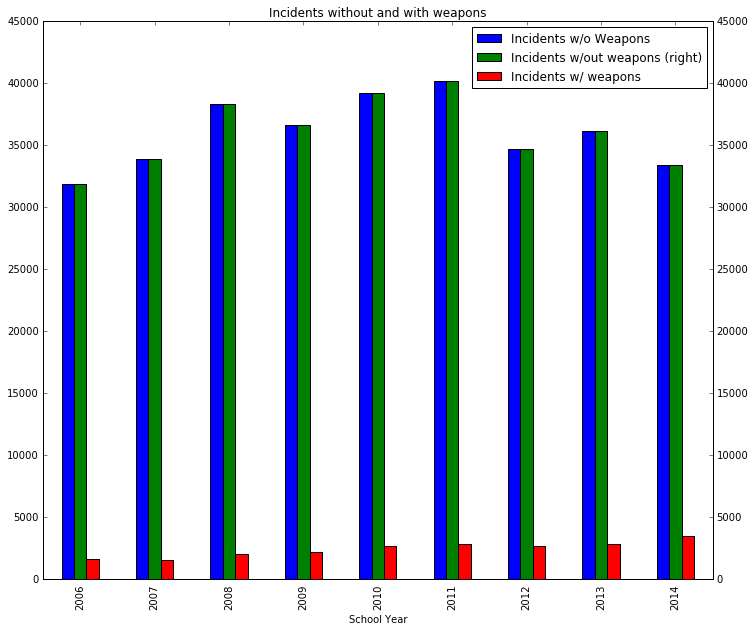

In [17]:
school_df["School Year"] = school_df["School Year"].astype(int)

if 'Incidents w/ Weapons' in school_df.columns:
    school_df.drop('Incidents w/ Weapons', axis =1, inplace=True)

if 'Incidents w/ Weapons.1' in school_df.columns:
    school_df.drop('Incidents w/ Weapons.1', axis =1, inplace=True)

if 'Incidents w/ weapons' in school_df.columns:
    school_df.drop('Incidents w/ weapons', axis =1, inplace=True)
    
if 'Incidents w/out weapons' in school_df.columns:
    school_df.drop('Incidents w/out weapons', axis =1, inplace=True)

nw_cols = [cols for cols in school_df.columns if 'nw' in cols]
school_df[nw_cols].sum(axis=1)
school_df["Incidents w/out weapons"] = school_df[nw_cols].sum(axis=1)

ww_cols = [cols for cols in school_df.columns if 'ww' in cols]
school_df[ww_cols].sum(axis=1)
school_df["Incidents w/ weapons"] = school_df[ww_cols].sum(axis=1)

inc_cols = [cols for cols in school_df.columns if cols.startswith("Inc")]
#school_df.drop(inc_cols[1], inplace = True, axis=1)
# school_df[inc_cols].head()

fig = school_df.groupby("School Year")[inc_cols].sum().plot(kind="bar", figsize = (12, 10), 
                                                      secondary_y = inc_cols[1], legend=True,
#                                                       xticks = range(2006,2016), 
                                                      title = "Incidents without and with weapons"
                                                      )

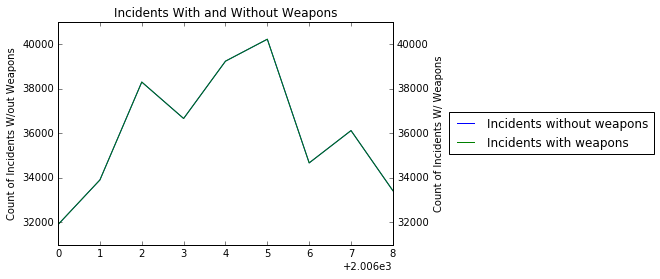

In [18]:
fig, ax = plt.subplots()

ax.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[0]].sum(),
        'b',
       label = "Incidents without weapons")
ax.set_ylabel("Count of Incidents W/out Weapons")

ax2 = ax.twinx()
ax2.plot(list(set(school_df["School Year"])), 
        school_df.groupby("School Year")[inc_cols[1]].sum(),
         'g',
       label = "Incidents with weapons")
ax2.set_ylabel("Count of Incidents W/ Weapons")

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc = "center left", bbox_to_anchor = (1.15, 0.5))
ax.set_title("Incidents With and Without Weapons")
plt.show()

----

# VI - Combining NYC Felony Data and NYC School Violence Data

## VI.I - Create Lat/Lon values using Geocoder based on school addresses from NYC School Directory data

In [19]:
# Finds which schools exist in both the violence and location dataframes

#location_df = pd.read_csv("15-16SchoolDirectory.csv") #removing this since this was imported above

loc_sed = set(location_df["SED CODE"].astype(np.int64))
sch_beds = set(school_df["BEDS Code"].astype(np.int64))
print("Location file school count:", len(loc_sed), "\nSchool violence school count:", len(sch_beds),
      "\nSchools with both violence and locations:", len(loc_sed & sch_beds))
school_beds_with_addresses = [x for x in sch_beds if x in (loc_sed & sch_beds)]
filtered_school_df = school_df[school_df["BEDS Code"].isin(school_beds_with_addresses)]
filtered_school_df.reset_index(inplace = True, drop = True)

Location file school count: 7200 
School violence school count: 1967 
Schools with both violence and locations: 1807


In [20]:
#Created a beds_df that will also house the lat lon info

location_df["Full_Address"] = location_df["MAILING ADDRESS"] + ", " + location_df["CITY"] + \
                                ", " + location_df["STATE"] + ", " + location_df["ZIP"]

beds_df = location_df[location_df['SED CODE'].isin(school_beds_with_addresses)][['SED CODE', 'LEGAL NAME', 'Full_Address']]

## WARNING: The next cell can only be run once a day.

It takes at least 10 minutes to run as well. This is a limitation of Google - only 2500 calls can be made per day and the cell below calls it 1,807 times.

In [ ]:
# Takes 10 min at least for all 1,807 schools! Only works ONCE A DAY due to geocoder 
# restrictions with Google (2,500 calls per day)

latlon = [geo.google(x).latlng for x in beds_df.Full_Address]
beds_df["latlon"] = latlon
beds_df.head()


## END WARNING

In [ ]:
# Add "Lat" and "Lon" columns on the filtered school dataframe

latlon_list = beds_df.latlon.tolist()
beds_df["Lat"] = [x[0] if x!=[] else [] for x in latlon_list]
beds_df["Lon"] = [x[1] if x!=[] else [] for x in latlon_list]
beds_df[["Full_Address", "Lat", "Lon"]].head()

In [ ]:
#save this off to csv since we can only run once per 24 hour period
beds_df.to_csv("SchoolLatLon.csv")

## VI.II - Lat Long Analysis

This portion of our project uses the schools' latitude and longitude (previously obtained using geocoder) to perform some final cleaning on the VADIR data and then join it to the NYC crime data by location. The code below will:  

* (A): __Join latlong data__ to the school data frame (using beds/sed code).
* (B): __Give schools consistent names__ (we'll use the names from the lat long file)  
* (C): __Identify felonies within a 1 mile__ radius of a given school.  
* (D): __Plot correlations__ between school indicents and felonies (by year, by borough, by felony type, by location, by school incident type).

### VI.II.A - Join School Data and Location Data

In [21]:
#import previously exported lat/lon data
latlon_df = pd.read_csv('SchoolLatLon.csv', index_col=0)

In [22]:
# Helper function -- extract lat/long from object type
def parse_latlong(dataframe, loc_column):
    """
    Function to extract lat/long coords. 
    INPUT: dataframe and name of column with string tuple or list pair of coordinates.
    OUTPUT: n/a. Function modifies dataframe to add a lat and long column with float type.
    """
    get_lat = lambda x: x.split(',')[0][1:] if type(x)==type('s') else np.nan
    get_long = lambda x: x.split(',')[1][:-1] if type(x)==type('s') else np.nan
    dataframe['lat'] = dataframe[loc_column].apply(get_lat).astype('float64')
    dataframe['long'] = dataframe[loc_column].apply(get_long).astype('float64')
    print('... latitude and longitude extracted for dataframe.')

In [23]:
# Helper function to add latitude and longitudes to school data frame
def join_latlong(school_df, latlon_df, talk=False):
    """
    Function to add (and parse)latitude and longitude 
    information for each school.
    INPUT: school dataframe including "BEDS Code" column,
           latitude/longitude dataframe w/ "SED CODE" col.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: dataframe with school data plut new columns 
            for 'LEGAL NAME', 'Full_Address', 'latlon'(obj),
            lat(float64) and long(float64).
    """
    # ensure BEDS and SED are integers so that they'll be recognized as identical
    latlon_df["SED CODE"] = latlon_df["SED CODE"].astype(np.int64)
    school_df["BEDS Code"] = school_df["BEDS Code"].astype(np.int64)
    
    # join latlong data to school data using the BEDS code
    school_df = pd.merge(school_df, latlon_df, left_on=['BEDS Code'],right_on=['SED CODE'], how='left')
    
    # parse latlon object in to numerical columns
    parse_latlong(school_df, 'latlon')
    
    # drop the now redundant SED code
    school_df.drop(['SED CODE'], axis=1, inplace=True)
    
    # Take a look at the resulting data/missing values
    if talk:
        print('... joined df inclues {} unique schools,'.format(len(school_df['BEDS Code'].unique())))
        schools_withloc = school_df[school_df['latlon'].notnull()]['BEDS Code'].unique()
        schools_missingloc = school_df[school_df['latlon'].isnull()]['BEDS Code'].unique()
        print('... of which {} have lat/long'.format(len(schools_withloc)),
              'and {} are missing lat/long'.format(len(schools_missingloc)))
        
    return school_df

In [24]:
# Function Call
school_df = join_latlong(school_df, latlon_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... latitude and longitude extracted for dataframe.
... joined df inclues 1967 unique schools,
... of which 1807 have lat/long and 160 are missing lat/long


### VI.II.B - Fix School Names using info from 'latlon' file.

In [25]:
# Helper Function
def fix_case(x):
    """Function to put a school name in the correct case"""
    if not x:
        return x
    elif x[:3] in ['PS ', 'JHS', 'MS ']:
        return x[:3] + x[3:].title()
    else:
        return x.title()

In [26]:
# Helper function to eliminate duplicated school names
def fix_school_names(school_df, talk=False):
    """ 
    INPUT: school_df with original 'School Name' column
           and with 'LEGAL NAME' column from latlong file.
           (optional 'talk' bool turns on/off print statements)
    OUTPUT: n/a, fxn modifies school_df to replace duplicate
           'School Name's with their (consistent) legal name.
    """
    if talk:
        print('... original dataset had {} unique'.format(len(school_df['School Name'].unique())),
              'school names but only {} unique BEDS Codes'.format(len(school_df['BEDS Code'].unique())))
    
    # Fix missing LEGAL NAMES with School Name
    school_df['LEGAL NAME'].fillna(school_df['School Name'], inplace=True)
    # Fix case and reassign to School Name
    school_df['School Name'] = school_df['LEGAL NAME'].apply(fix_case)
    # drop the now redundant LEGAL NAME column
    school_df.drop(['LEGAL NAME'], axis=1, inplace=True)
    
    if talk:
        print('... new dataset has {} unique school '.format(len(school_df['School Name'].unique())),
              'names and {} unique BEDS Codes.'.format(len(school_df['BEDS Code'].unique())))

In [27]:
# function call
fix_school_names(school_df, talk=True)

# Take a look -- uncomment to run
#school_df.head(2)

... original dataset had 3135 unique school names but only 1967 unique BEDS Codes
... new dataset has 1959 unique school  names and 1967 unique BEDS Codes.


### VI.II.C - Extracting crime tallies w/in radius of schools

The functions below build together to ultimately 'join' our two datasets by adding columns to the school dataset for tallies of each type of felony that occurred w/in a 1 mile radius. 

#### Part 1: Distance Calculation using Vincenty

In [28]:
# Quick Check, are there rows with 'latlon' but not 'lat'
print('... there are {} missing latlon entries'.format(sum(school_df.latlon.isnull())))
print('... there are {} missing lat entries'.format(sum(school_df.lat.isnull())))

... there are 640 missing latlon entries
... there are 640 missing lat entries


In [29]:
# Helper function -- check dist
def is_in_radius(school_point, crime_point, radius):
    """
    Function using vincenty package to check distance between school and crime.
    INPUT: (lat,long) tuples for school and crime (in degrees), radius in miles.
    OUTPUT: Boolean
    """
    return vincenty(school_point, crime_point, miles=True) <= radius

In [65]:
#ensure that lat and long columns are added to the felony_df as well
#and reset index
parse_latlong(felony_df, 'Location 1')
felony_df = felony_df.reset_index()

... latitude and longitude extracted for dataframe.


In [67]:
# Testing vincenty on the first felony and first school
first_school_point = (school_df.loc[0,'lat'], school_df.loc[0,'long']) 
first_felony_point = (felony_df.loc[1,'lat'], felony_df.loc[1,'long']) 

# not w/in 2 miles, but yes, w/in 50
print('Distance: ', vincenty(first_school_point, first_felony_point))
print("... w/in 2 mi?", is_in_radius(first_school_point, first_felony_point, 2))
print("... w/in 50 mi?",is_in_radius(first_school_point, first_felony_point, 50))

Distance:  24.058529
... w/in 2 mi? False
... w/in 50 mi? True


#### Part 2: Setting up a grid for NYC lat/long coords

The goal is to use a grid strategy to avoid searching the entire NYC Felony dataframe for each school location (which would take too long).

NOTES: The max lat of a school is ~ 40.9  and the distance between 40.9 and 40.95 is over 3 miles... but there are 7 crimes that fell under the jurisdiction of the NY Transit police whose locations are recorded north of 41 degrees (the farthes one is 500 miles away). The minimum longitude of a school is ~-74.24 which is around 3 miles from -74.3. There are 63 crimes that occurred west of -74.3. I suggest that we disregard these outliers for the purposes of our analysis

In [68]:
# Initial exploration of ranges
max_lat = school_df.lat.max()
min_lat = school_df.lat.min()
max_long = school_df.long.max()
min_long = school_df.long.min()

lat_dist = vincenty((min_lat, 0.5*(max_long + min_long)),(max_lat, 0.5*(max_long + min_long)), miles=True)
long_dist = vincenty((min_long, 0.5*(max_lat + min_lat)),(max_long, 0.5*(max_lat + min_lat)), miles=True)

print('Latitude ranges from {} to {} with a total distance of {}'.format(min_lat, max_lat, lat_dist))
print('Longitude ranges from {} to {} with a total distance of {}'.format(min_long, max_long, long_dist))

Latitude ranges from 40.5078027 to 40.9034547 with a total distance of 27.300837
Longitude ranges from -74.2440251 to -73.4883134 with a total distance of 52.408039


In [69]:
# Helper function to identify grid cell that contains a given point
def nyc_grid(lat,long):
    """
    This function identifies a square mile cell of NYC that contains 
    the given longitude and latitude point. There are 1500 cells in 
    total. 30 rows each represent a segement of latitude and 50 
    columns each represent a segment of longitude. The cells are 
    numbered 0 through 1599 and they are unique to this analysis.
    """
    # max and min values from data set
    max_lat = 40.95
    min_lat = 40.50
    max_long = -73.45
    min_long = -74.30
    
    # divide each range into segments of a little over a mile
    delta_lat = (max_lat - min_lat)/28
    delta_long = (max_long - min_long)/48

    # then segment each direction
    lat_seg = np.array([min_lat + idx*delta_lat for idx in range(-1,29)])
    long_seg = np.array([min_long + idx*delta_long for idx in range(-1,49)])

    # identify where given point fits in segments
    row = sum(lat_seg <= lat) - 1
    col = sum(long_seg <= long) - 1
    
    # return grid number
    if row < 0 or row == 29 or col < 0 or col == 49:
        return np.nan
    else:
        return row * 50 + col

In [70]:
# Test an out of bound point
nyc_grid(40.653161, -76.862164)

nan

In [71]:
# Test an in bound point
nyc_grid(40.821798, -73.886463)

1074

In [79]:
#add NYC_grid column to felony_df
#WARNING - takes about 4 minutes to run
felony_df['NYC_grid'] = felony_df.lat.combine(felony_df.long, func=nyc_grid)


#### Part 3: Function to find crimes w/in 1 mile of a school

STRATEGY: Identify the grid cell containing the school and then search only that cell and its immediately adjacent cells.

In [81]:
# helper function to get a list of adjacent cells
def get_adjacent(cell_num):
    """ 
    This function identifies a group of cells which together superset 
    any points within a mile of any location in the original cell.
    INPUT: a cell number (< 5999) from NYC grid
    OUTPUT: a list of adjacent and or diagonal cell numbers
    
    NOTE: this function should only be run on cell numbers of vadir
    school locations since the nyc_grid is designed so that all
    schools are in a cell that is not a boarder cell.
    """
    col = cell_num % 50
    row = cell_num // 50
    row_range = [row - 1, row, row + 1]
    col_range = [col - 1, col, col + 1]
    return [r * 50 + c for r in row_range for c in col_range]
    

In [82]:
# Test grid adjacency
get_adjacent(52)

[1, 2, 3, 51, 52, 53, 101, 102, 103]

In [83]:
# helper function to get subset of felonies within a 1 mile radius
def get_local_crimes(location, felony_df):
    """
    This function identifies crimes less than 1 mi 
    from a single school (or GPS location).
    INPUT: location (GPS point), felony_df (w/
        'NYC_grid column already populated)
    OUTPUT: felony_df subset of crimes that 
        occurred within one mile of school.
            
    """
    cells_to_search = get_adjacent(nyc_grid(*location))
    
    # Get subset of crimes w/in grid
    cells_to_search = get_adjacent(nyc_grid(*location)) 
    crimes = felony_df.loc[felony_df.NYC_grid.isin(cells_to_search)]
    
    # Further subset by a radius of 1 mile
    if not crimes.empty: 
        r_filter = lambda x: is_in_radius(location,(x.lat,x.long),1)
        crimes =  crimes[crimes.apply(r_filter, axis=1)]
        
    return crimes

In [84]:
# test function on a single school / no crimes
this_school = school_df[school_df['BEDS Code'] == 307500014256]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

In [85]:
# now testing on a school with crimes
this_school = school_df[school_df['BEDS Code'] == 307500012017]
location = (this_school.lat.mean(), this_school.long.mean())
result = get_local_crimes(location, felony_df)

In [86]:
result

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,...,XCoordinate,YCoordinate,Location 1,Short Occurrence Date,Occurrence Month Ordered,Day of Week Ordered,School Year,lat,long,NYC_grid
19,278,921c5b6d,01/09/2006 01:45:00 AM,Monday,Jan,9,2006,1,1,9,...,1009734,240955,"(40.8280127790001, -73.9079177789999)",2006-01-09,01(Jan),1 (Mon),2005,40.828013,-73.907918,1073
157,420,8a38fca4,01/09/2006 12:00:00 PM,Monday,Jan,9,2006,12,7,19,...,1006687,239755,"(40.8247273870001, -73.9189317889999)",2006-01-09,01(Jan),1 (Mon),2005,40.824727,-73.918932,1072
167,430,23d7f236,01/09/2006 01:00:00 PM,Monday,Jan,9,2006,13,1,10,...,1012440,237118,"(40.817473083, -73.8981560679999)",2006-01-09,01(Jan),1 (Mon),2005,40.817473,-73.898156,1023
190,453,336a862b,01/09/2006 02:00:00 PM,Monday,Jan,9,2006,14,1,9,...,1008624,236597,"(40.816054438, -73.9119444689999)",2006-01-09,01(Jan),1 (Mon),2005,40.816054,-73.911944,1022
197,460,68a89255,01/09/2006 02:50:00 PM,Monday,Jan,9,2006,14,1,9,...,1010131,240105,"(40.825678618, -73.9064865409999)",2006-01-09,01(Jan),1 (Mon),2005,40.825679,-73.906487,1073
245,509,96b32020,01/09/2006 04:20:00 PM,Monday,Jan,9,2006,16,1,9,...,1009920,236872,"(40.816805565, -73.907261306)",2006-01-09,01(Jan),1 (Mon),2005,40.816806,-73.907261,1023
272,536,27131749,01/09/2006 05:50:00 PM,Monday,Jan,9,2006,17,1,9,...,1014160,239740,"(40.8246640730001, -73.891930338)",2006-01-09,01(Jan),1 (Mon),2005,40.824664,-73.891930,1074
344,608,6df42676,01/09/2006 09:20:00 PM,Monday,Jan,9,2006,21,1,9,...,1010535,241299,"(40.8289546130001, -73.9050221059999)",2006-01-09,01(Jan),1 (Mon),2005,40.828955,-73.905022,1073
419,685,ec737340,01/10/2006 03:30:00 AM,Tuesday,Jan,10,2006,3,1,10,...,1007333,234402,"(40.8100332440001, -73.916616065)",2006-01-10,01(Jan),2 (Tues),2005,40.810033,-73.916616,1022
523,790,93b03d9f,01/10/2006 12:00:00 PM,Tuesday,Jan,10,2006,12,2,19,...,1007648,235115,"(40.8119894020001, -73.91547567)",2006-01-10,01(Jan),2 (Tues),2005,40.811989,-73.915476,1022


#### Part 4: Crime counting function to search only within adjacent cells of the school

NOTE: loading grid cell#s for the felony data set takes 3-4 minutes and only needs to be done once. To skip that step after you've already run this function before simply set the optional parameter skip_gridsetup to True (it defaults False)

In [87]:
def tally_crime_by_loc(school_df, felony_df, skip_gridsetup = False):
    """
    Function to tally and store information about felonies 
    that occur w/in one mile of each school in the school_df.
    INPUT: school df w/ cols 'latlon', 'lat', 'long', and 'School Year'
           felony df w/ cols 'Occurrence Year', 'lat','long','Offense', and 'Identifier'
    OUTPUT: n/a, modifies school data.
    """
    if not skip_gridsetup:
        # prepare felony dataframe by adding a column for nyc_grid cell number
        felony_df.lat.fillna(0, inplace=True)
        felony_df.long.fillna(0, inplace=True)
        felony_df['NYC_grid'] = felony_df.apply(lambda x: nyc_grid(x.lat, x.long),axis=1)

    # Initialize new columns in school data frame
    school_df['CrimeIDS'] = pd.Series()
    school_df['Total Felonies w/in 1mi'] = pd.Series()
    school_df['Grand Larceny w/in 1mi'] = pd.Series()
    school_df['Robbery w/in 1mi'] = pd.Series()
    school_df['Burglary w/in 1mi'] = pd.Series()
    school_df['Assault w/in 1mi'] = pd.Series()
    school_df['Auto Theft w/in 1mi'] = pd.Series()
    school_df['Rape w/in 1mi'] = pd.Series()
    school_df['Murders w/in 1mi'] = pd.Series()
    
    # Group schools (unique location for each BEDS Code) 
    grouped = school_df[school_df.lat.notnull()].groupby(['BEDS Code'])
    
    # Loop through schools, subset crime by location. 
    for beds, df in grouped:
        # NOTE: the coordinates should all be the same so the mean is just the location
        assert len(df.lat.unique().tolist()) == 1, 'ERROR: multiple latitudes for this school.'
        location = (df.lat.mean(), df.long.mean())
        local_crimes = get_local_crimes(location, felony_df)

        # tally and store felonies for each year
        for year in df['School Year'].unique():
            subset = local_crimes[local_crimes['School Year'] == year]
            idxs = df[df['School Year'] == year].index.tolist()
            school_df.loc[idxs,['CrimeIDS']] = str(subset.Identifier.unique().tolist())
            school_df.loc[idxs,['Total Felonies w/in 1mi']] = len(subset)        
            school_df.loc[idxs,['Grand Larceny w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY')
            school_df.loc[idxs,['Robbery w/in 1mi']] = sum(subset['Offense'] == 'ROBBERY')
            school_df.loc[idxs,['Burglary w/in 1mi']] = sum(subset['Offense'] == 'BURGLARY')
            school_df.loc[idxs,['Assault w/in 1mi']] = sum(subset['Offense'] == 'FELONY ASSAULT')
            school_df.loc[idxs,['Auto Theft w/in 1mi']] = sum(subset['Offense'] == 'GRAND LARCENY OF MOTOR VEHICLE')
            school_df.loc[idxs,['Rape w/in 1mi']] = sum(subset['Offense'] == 'RAPE')
            school_df.loc[idxs,['Murders w/in 1mi']] = sum(subset['Offense'] == 'MURDER & NON-NEGL. MANSLAUGHTE')

    print('... tallied felonies w/in 1 mile of each school.')

In [ ]:
# WARNING ... this cell takes around and hour and half to run (~5 seconds per school)
# Try importing: 'vadir_with_felonycounts.csv' for a faster option

# run function
tally_crime_by_loc(school_df, felony_df)


In [ ]:
school_df.to_csv('vadir_with_felonycounts.csv')

### VI.II.D - Exploring the data

In [ ]:
# Shortcut to data - uncomment to run.
#school_df = pd.read_csv('vadir_with_felonycounts.csv')

In [ ]:
school_df.groupby('County')['Robbery w/in 1mi','Total Incidents'].mean().plot(kind='bar', legend=True)

In [ ]:
school_df.plot(x='Total Incidents', y='Total Felonies w/in 1mi', kind='scatter')

In [ ]:
school_df.plot(x='Total Incidents' , y='Burglary w/in 1mi', kind='scatter')

In [ ]:
school_df.plot(x='Total Incidents' , y='Assault w/in 1mi', kind='scatter')

In [ ]:
school_df.plot(x='Robbery w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')

In [ ]:
school_df.plot(x='Burglary w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')

In [ ]:
school_df.plot(x='Grand Larceny w/in 1mi' , y='Total Felonies w/in 1mi', kind='scatter')